# Load Data and Word-Embedding Models

In [1]:
import os
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('train_data.json', 'r'))
val_data = json.load(open('val_data.json', 'r'))
test_data = json.load(open('test_data.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# BiLSTM-CRF Implementation


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class BiLSTM_CRF(nn.Module):
    def __init__(self, input_size, hidden_size, num_tags):
        super(BiLSTM_CRF, self).__init__()
        self.hidden_size = hidden_size
        self.num_tags = num_tags

        # BiLSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size//2, batch_first=True, bidirectional=True)
        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_size, num_tags)
        # CRF layer
        self.crf = CRF(num_tags)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def neg_log_likelihood(self, x, tags):
        emissions = self(x)
        return -self.crf(emissions, tags)

    def forward_crf(self, x):
        emissions = self(x)
        out = self.crf.decode(emissions)
        out = torch.tensor(out)
        out = torch.nn.functional.one_hot(out, num_classes=self.num_tags)
        out = out.permute(1, 0, 2) # (len, 1, num_tags) to (1, len, num_tags)
        return out

# Training and Validation Code

In [4]:
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {"B": 0, "I": 1, "O": 2}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            targets = targets.squeeze(0)
            loss = criterion(outputs.float().view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"].split()
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                targets = targets.squeeze(0)
                loss = criterion(outputs.float().view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Testing Code

In [5]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {"B": 0, "I": 1, "O": 2}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)  
            targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            targets = targets.squeeze(0)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
        
    if show_labelwise:
        import matplotlib.pyplot as plt
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [6]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [7]:
input_size = 300  # Embedding size
hidden_size = 128  # Hidden size of the RNN
output_size = 3   # BIO encoding: B, I, O

# For Word2Vec Embeddings

In [28]:
bilstmcrf_word2vec_model = BiLSTM_CRF(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstmcrf_word2vec_model.parameters(), lr=0.001)

In [29]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            bilstmcrf_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.2671, Accuracy: 0.9166, F1: 0.6275
Validation: Loss: 0.1611, Accuracy: 0.9471, F1: 0.7831
Epoch 2/10
Training: Loss: 0.1594, Accuracy: 0.9444, F1: 0.7904
Validation: Loss: 0.1469, Accuracy: 0.9492, F1: 0.7863
Epoch 3/10
Training: Loss: 0.1220, Accuracy: 0.9572, F1: 0.8410
Validation: Loss: 0.1459, Accuracy: 0.9504, F1: 0.7922
Epoch 4/10
Training: Loss: 0.0943, Accuracy: 0.9655, F1: 0.8765
Validation: Loss: 0.1493, Accuracy: 0.9514, F1: 0.8022
Epoch 5/10
Training: Loss: 0.0699, Accuracy: 0.9736, F1: 0.9076
Validation: Loss: 0.1554, Accuracy: 0.9514, F1: 0.8039
Epoch 6/10
Training: Loss: 0.0501, Accuracy: 0.9808, F1: 0.9360
Validation: Loss: 0.1604, Accuracy: 0.9526, F1: 0.8095
Epoch 7/10
Training: Loss: 0.0355, Accuracy: 0.9871, F1: 0.9578
Validation: Loss: 0.1666, Accuracy: 0.9528, F1: 0.8111
Epoch 8/10
Training: Loss: 0.0242, Accuracy: 0.9919, F1: 0.9735
Validation: Loss: 0.1817, Accuracy: 0.9516, F1: 0.8020
Epoch 9/10
Training: Loss: 0.0196, Accuracy: 0.9

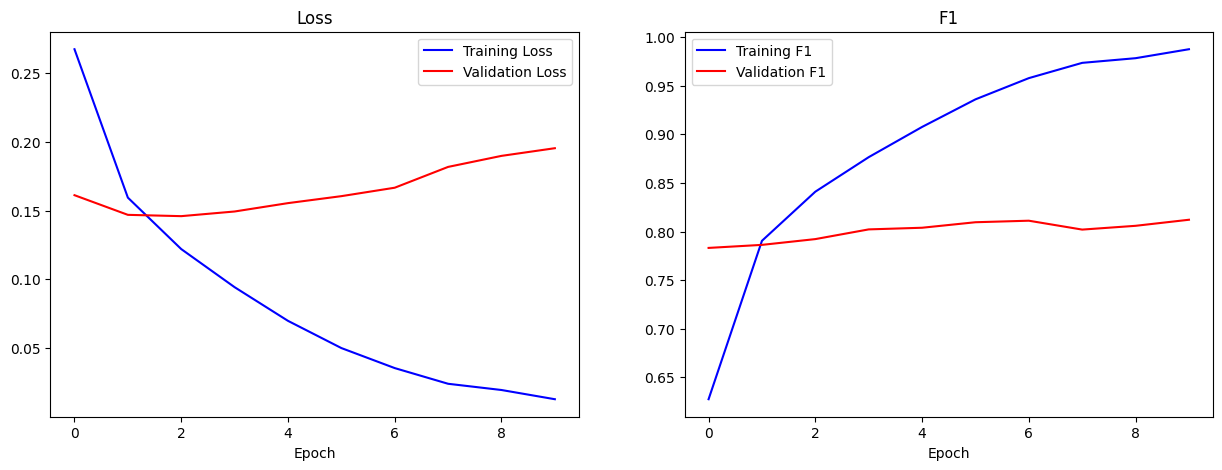

In [30]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [31]:
bilstmcrf_word2vec_model = bilstmcrf_word2vec_model.to('cpu')
torch.save(bilstmcrf_word2vec_model, "t2_model4_word2vec.pt")

Labelwise F1 Scores:
{0: 0.2893235533822331, 1: 0.2447916666666667, 2: 0.32844752490247325}
Labelwise Accuracy Scores:
{0: 0.7667386609071274, 1: 0.5802469135802469, 2: 0.9711086226203808}


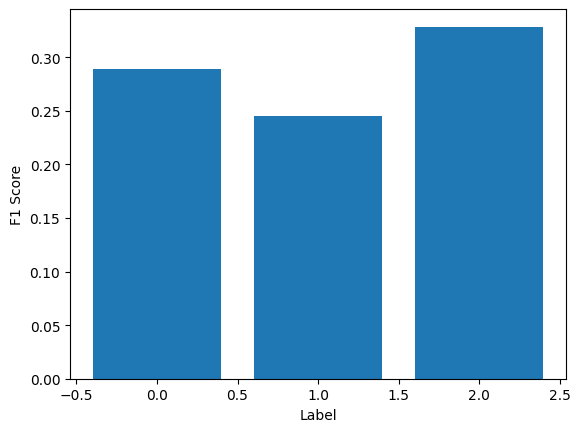

Bi-LSTM CRF with Word2Vec ==> Accuracy: 0.9344, F1: 0.7916


In [32]:
test_accuracy, test_f1 = test("t2_model4_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=True)
print(("Bi-LSTM CRF with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

# For GloVe Embeddings

In [13]:
bilstmcrf_glove_model = BiLSTM_CRF(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstmcrf_glove_model.parameters(), lr=0.001)

In [14]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            bilstmcrf_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10


Training: Loss: 0.2864, Accuracy: 0.9128, F1: 0.5918
Validation: Loss: 0.1979, Accuracy: 0.9346, F1: 0.6832
Epoch 2/10
Training: Loss: 0.1863, Accuracy: 0.9385, F1: 0.7528
Validation: Loss: 0.1789, Accuracy: 0.9394, F1: 0.7180
Epoch 3/10
Training: Loss: 0.1368, Accuracy: 0.9525, F1: 0.8148
Validation: Loss: 0.1791, Accuracy: 0.9437, F1: 0.7426
Epoch 4/10
Training: Loss: 0.0981, Accuracy: 0.9658, F1: 0.8715
Validation: Loss: 0.1873, Accuracy: 0.9432, F1: 0.7506
Epoch 5/10
Training: Loss: 0.0711, Accuracy: 0.9752, F1: 0.9091
Validation: Loss: 0.2058, Accuracy: 0.9430, F1: 0.7445
Epoch 6/10
Training: Loss: 0.0514, Accuracy: 0.9825, F1: 0.9365
Validation: Loss: 0.2217, Accuracy: 0.9444, F1: 0.7553
Epoch 7/10
Training: Loss: 0.0402, Accuracy: 0.9859, F1: 0.9492
Validation: Loss: 0.2419, Accuracy: 0.9423, F1: 0.7405
Epoch 8/10
Training: Loss: 0.0310, Accuracy: 0.9905, F1: 0.9670
Validation: Loss: 0.2527, Accuracy: 0.9425, F1: 0.7420
Epoch 9/10
Training: Loss: 0.0263, Accuracy: 0.9916, F1: 0.

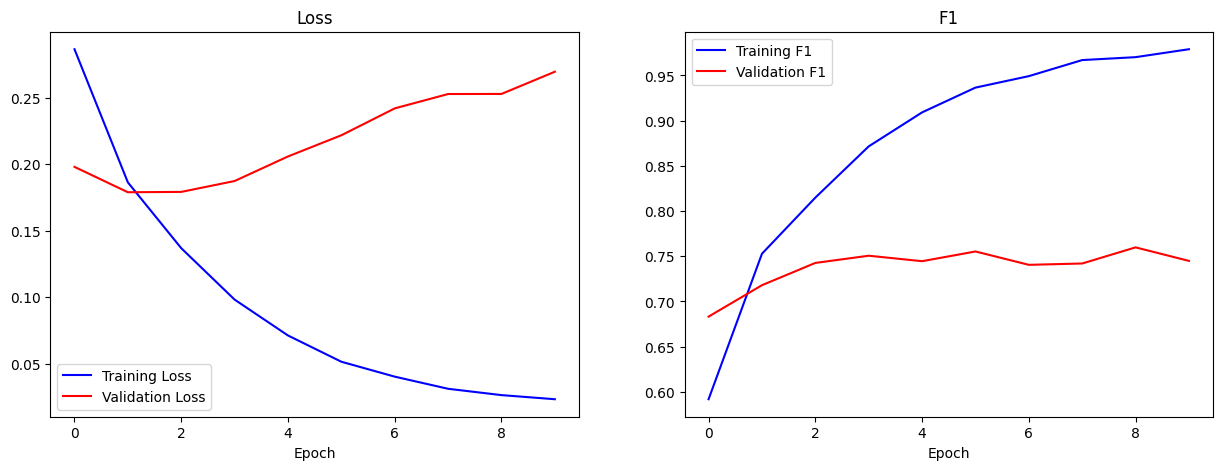

In [15]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [16]:
bilstmcrf_glove_model = bilstmcrf_glove_model.to('cpu')
torch.save(bilstmcrf_glove_model, "t2_model4_glove.pt")

Labelwise F1 Scores:
{0: 0.2621231979030144, 1: 0.22882882882882882, 2: 0.327677181794025}
Labelwise Accuracy Scores:
{0: 0.6479481641468683, 1: 0.522633744855967, 2: 0.966629339305711}


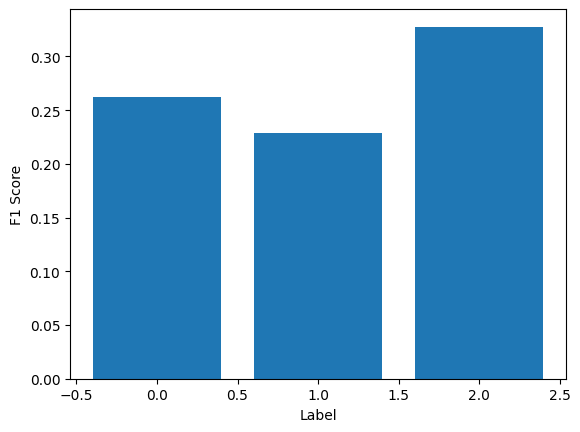

Bi-LSTM CRF with GloVe ==> Accuracy: 0.9172, F1: 0.7405


In [17]:
test_accuracy, test_f1 = test("t2_model4_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=True)
print(("Bi-LSTM CRF with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

# For FastText Embeddings

In [44]:
bisltmcrf_fasttext_model = BiLSTM_CRF(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bisltmcrf_fasttext_model.parameters(), lr=0.001)

In [45]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        bisltmcrf_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=5)

Epoch 1/5
Training: Loss: 0.2989, Accuracy: 0.9102, F1: 0.5332
Validation: Loss: 0.1742, Accuracy: 0.9353, F1: 0.7028
Epoch 2/5
Training: Loss: 0.1718, Accuracy: 0.9359, F1: 0.7521
Validation: Loss: 0.1498, Accuracy: 0.9466, F1: 0.7688
Epoch 3/5
Training: Loss: 0.1428, Accuracy: 0.9459, F1: 0.7978
Validation: Loss: 0.1434, Accuracy: 0.9473, F1: 0.7764
Epoch 4/5
Training: Loss: 0.1217, Accuracy: 0.9537, F1: 0.8324
Validation: Loss: 0.1413, Accuracy: 0.9492, F1: 0.7918
Epoch 5/5
Training: Loss: 0.1032, Accuracy: 0.9610, F1: 0.8614
Validation: Loss: 0.1451, Accuracy: 0.9504, F1: 0.7947


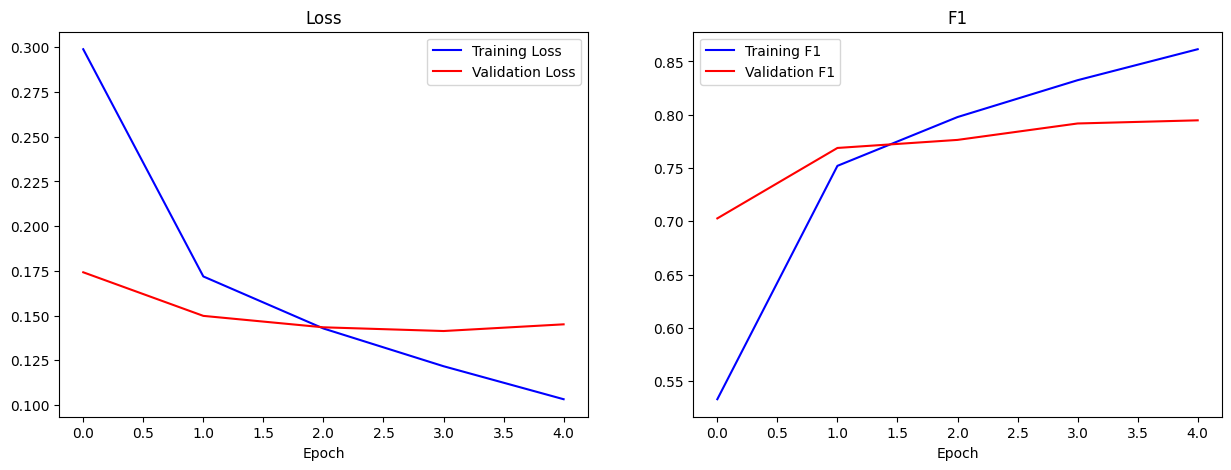

In [46]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [47]:
bisltmcrf_fasttext_model = bisltmcrf_fasttext_model.to('cpu')
torch.save(bisltmcrf_fasttext_model, "t2_model4_fasttext.pt")

Labelwise F1 Scores:
{0: 0.276936026936027, 1: 0.2458874458874459, 2: 0.32986346835634}
Labelwise Accuracy Scores:
{0: 0.7105831533477321, 1: 0.5843621399176955, 2: 0.9793952967525196}


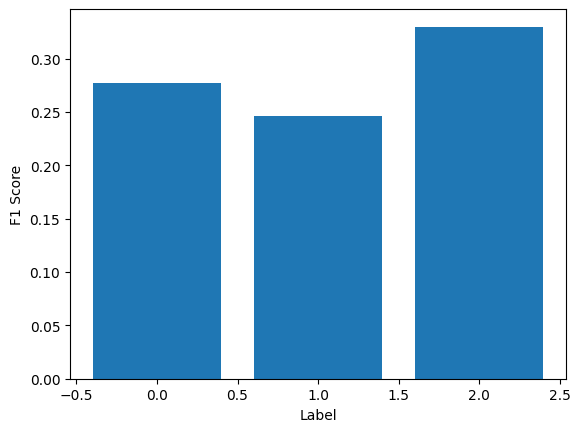

Bi-LSTM CRF with FastText ==> Accuracy: 0.9368, F1: 0.7970


In [48]:
test_accuracy, test_f1 = test("t2_model4_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=True)
print(("Bi-LSTM CRF with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))